##1. 準備

In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install pybullet gym==0.21.0
!apt update
!apt install xvfb
!pip install pybullet gym-notebook-wrapper

In [ ]:
import time
import os
import gc
import random

import numpy as np
import matplotlib.pyplot as plt

import gym
import pybullet_envs
import torch
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_


import glob
from collections import deque
from time import time
from datetime import timedelta
import pickle
from base64 import b64encode
import math
import gnwrapper
from typing import Tuple, List, Optional

%matplotlib inline
import matplotlib.pyplot as plt

gym.logger.set_level(40)

In [ ]:
def make_env(seed=1234):
    env = gym.make('HalfCheetahBulletEnv-v0')
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env

In [ ]:
class TrainedModels:
    def __init__(self, *models) -> None:
        assert np.all([nn.Module in model.__class__.__bases__ for model in models]), "Arguments for TrainedModels need to be nn models."
        self.models = models

    def save(self, dir: str) -> None:
        for i, model in enumerate(self.models):
            torch.save(
                model.state_dict(),
                os.path.join(dir, f"{str(i + 1).zfill(2)}.pt")
            )

    def load(self, dir: str, device: str) -> None:
        for i, model in enumerate(self.models):
            model.load_state_dict(
                torch.load(
                    os.path.join(dir, f"{str(i + 1).zfill(2)}.pt"),
                    map_location=device
                )
            )

In [ ]:
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 2. モデルの実装








In [ ]:
def torch_log(x):
    return torch.log(x + 1e-6)

def calculate_log_pi(log_stds, noises, actions):
    gaussian_log_probs = \
        (-0.5 * noises.pow(2) - log_stds).sum(dim=-1, keepdim=True) - 0.5 * math.log(2 * math.pi) * log_stds.size(-1)

    log_pis = gaussian_log_probs - torch_log(1 - actions.pow(2)).sum(dim=-1, keepdim=True)

    return log_pis


def reparameterize(means, log_stds):
    stds = log_stds.exp()
    noises = torch.randn_like(means)
    us = means + noises * stds
    actions = torch.tanh(us)
    log_pis = calculate_log_pi(log_stds, noises, actions)

    return actions, log_pis

In [ ]:
class PPOActor(nn.Module):
    def __init__(self, state_shape, action_shape, hidden=64):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, action_shape[0]),
        )
        self.log_stds = nn.Parameter(torch.zeros(1, action_shape[0]))

    def forward(self, states):
        return torch.tanh(self.net(states))

    def sample(self, states):
        means = self.net(states)
        return reparameterize(means, self.log_stds)

    @staticmethod
    def atanh(x):
        return 0.5 * (torch_log(1 + x) - torch_log(1 - x))

    def evaluate_log_pi(self, states, actions):
        means = self.net(states)
        noises = (self.atanh(actions) - means) / (self.log_stds.exp() + 1e-8)

        return calculate_log_pi(self.log_stds, noises, actions)

In [ ]:
class PPOCritic(nn.Module):
    def __init__(self, state_shape, hidden=64) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )

    def forward(self, states) -> torch.Tensor:
        return self.net(states)

In [ ]:
def calculate_advantage(values, rewards, dones, next_values, gamma=0.995, lambd=0.997):
    deltas = rewards + gamma * next_values * (1 - dones) - values
    advantages = torch.empty_like(rewards)
    advantages[-1] = deltas[-1]

    for t in reversed(range(rewards.size(0) - 1)):
        advantages[t] = deltas[t] + gamma * lambd * (1 - dones[t]) * advantages[t + 1]

    targets = advantages + values
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return targets, advantages

In [ ]:
class RolloutBuffer:
    def __init__(self, buffer_size, state_shape, action_shape, device=torch.device('cuda')):
        self.states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)
        self.actions = torch.empty((buffer_size, *action_shape), dtype=torch.float, device=device)
        self.rewards = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.dones = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.log_pis = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.next_states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)
        self._p = 0
        self.buffer_size = buffer_size

    def append(self, state, action, reward, done, log_pi, next_state):
        self.states[self._p].copy_(torch.from_numpy(state))
        self.actions[self._p].copy_(torch.from_numpy(action))
        self.rewards[self._p] = float(reward)
        self.dones[self._p] = float(done)
        self.log_pis[self._p] = float(log_pi)
        self.next_states[self._p].copy_(torch.from_numpy(next_state))
        self._p = (self._p + 1) % self.buffer_size

    def get(self):
        return self.states, self.actions, self.rewards, self.dones, self.log_pis, self.next_states

    def clear(self):
        self.states = torch.empty_like(self.states)
        self.actions = torch.empty_like(self.actions)
        self.rewards = torch.empty_like(self.rewards)
        self.dones = torch.empty_like(self.dones)
        self.log_pis = torch.empty_like(self.log_pis)
        self.next_states = torch.empty_like(self.next_states)
        self._p = 0

In [ ]:
class PPO:
    def __init__(
        self, state_shape, action_shape, device=torch.device('cuda'),
        batch_size=64, gamma=0.995, lr_actor=3e-4, lr_critic=1e-3, buffer_size=2048,
        horizon=2048, num_updates=10, num_steps=None, clip_eps=0.2, lambd=0.97,
        coef_ent=0.0, max_grad_norm=0.5, max_action=1.
    ):

        self.buffer = RolloutBuffer(
            buffer_size=buffer_size,
            state_shape=state_shape,
            action_shape=action_shape,
            device=device
        )

        self.actor = PPOActor(
            state_shape=state_shape,
            action_shape=action_shape,
        ).to(device)
        self.critic = PPOCritic(
            state_shape=state_shape,
        ).to(device)

        self.optim_actor = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optim_critic = torch.optim.Adam(self.critic.parameters(), lr=lr_critic)

        if num_steps is not None:
            self.sched_actor = torch.optim.lr_scheduler.CosineAnnealingLR(
                self.optim_actor,
                T_max=num_steps//horizon,
                eta_min=lr_actor*0.01
            )
            self.sched_critic = torch.optim.lr_scheduler.CosineAnnealingLR(
                self.optim_critic,
                T_max=num_steps//horizon,
                eta_min=lr_critic*0.01
            )

        self.learning_steps = 0
        self.device = device
        self.batch_size = batch_size
        self.gamma = gamma
        self.horizon = horizon
        self.buffer_size = buffer_size
        self.num_updates = num_updates
        self.num_steps = num_steps
        self.clip_eps = clip_eps
        self.lambd = lambd
        self.coef_ent = coef_ent
        self.max_grad_norm = max_grad_norm
        self.max_action = max_action

    def is_update(self, steps: int) -> bool:
        return steps % self.horizon == 0

    @torch.no_grad()
    def explore(self, state) -> Tuple[np.ndarray, float]:
        state = torch.from_numpy(state.astype(np.float32)).to(self.device).unsqueeze(0)
        action, log_pi = self.actor.sample(state)

        return action.cpu().numpy()[0] * self.max_action, log_pi.item()

    @torch.no_grad()
    def exploit(self, state) -> np.ndarray:
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        action = self.actor(state)

        return action.cpu().numpy()[0] * self.max_action

    @torch.no_grad()
    def get_value(self, state) -> np.ndarray:
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        value = self.critic(state)

        return value.cpu().numpy()[0]

    def step(self, env, state: np.ndarray, t: int, steps: int) -> Tuple[np.ndarray, int]:
        t += 1

        action, log_pi = self.explore(state)
        next_state, reward, done, _ = env.step(action)

        if t == env._max_episode_steps:
            done_masked = False
        else:
            done_masked = done

        self.buffer.append(state, action, reward, done_masked, log_pi, next_state)

        if done:
            t = 0
            next_state = env.reset()

        return next_state, t

    def update(self) -> None:
        self.learning_steps += 1
        states, actions, rewards, dones, log_pis, next_states = self.buffer.get()

        with torch.no_grad():
            values = self.critic(states)
            next_values = self.critic(next_states)

        targets, advantages = calculate_advantage(
            values, rewards, dones, next_values, self.gamma, self.lambd
        )

        for _ in range(self.num_updates):
            indices = np.arange(self.buffer_size)
            np.random.shuffle(indices)

            for start in range(0, self.buffer_size, self.batch_size):
                idxes = indices[start:start+self.batch_size]
                self.update_critic(states[idxes], targets[idxes])
                self.update_actor(states[idxes], actions[idxes], log_pis[idxes], advantages[idxes])

        if self.num_steps is not None:
            self.sched_critic.step()
            self.sched_actor.step()

    def update_critic(self, states, targets) -> None:
        loss_critic = F.mse_loss(self.critic(states), targets)

        self.optim_critic.zero_grad()
        loss_critic.backward(retain_graph=False)
        nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
        self.optim_critic.step()

    def update_actor(self, states, actions, log_pis_old, advantages) -> None:
        log_pis = self.actor.evaluate_log_pi(states, actions)

        ratios = (log_pis - log_pis_old).exp_()

        loss_actor1 = -ratios * advantages
        loss_actor2 = -torch.clamp(
            ratios,
            1.0 - self.clip_eps,
            1.0 + self.clip_eps
            ) * advantages

        mean_entropy = -log_pis.mean()

        loss_actor = torch.max(loss_actor1, loss_actor2).mean() - self.coef_ent * mean_entropy

        self.optim_actor.zero_grad()
        loss_actor.backward(retain_graph=False)
        nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
        self.optim_actor.step()

## 3. モデルの学習  

In [ ]:
returns = {'step': [], 'return': []}

def evaluate_policy(steps, eval_episodes=3):
    _returns = []
    for _ in range(eval_episodes):
        state = env_test.reset()
        done = False
        episode_return = 0.0

        while (not done):
            action = algo.exploit(state)
            state, reward, done, _ = env_test.step(action)
            episode_return += reward

        _returns.append(episode_return)

    mean_return = np.mean(_returns)
    returns['step'].append(steps)
    returns['return'].append(mean_return)

    print(
        f'Num steps: {steps:<6}   '
        f'Return: {mean_return:<5.1f}   '
        f'Time elapsed: {str(timedelta(seconds=int(time() - start_time)))}'
    )

In [ ]:
set_seed(1234)
env = make_env()
env_test = make_env()

NUM_STEPS = 3 * 10 ** 6
EVAL_INTERVAL = 10 ** 4

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    num_steps=NUM_STEPS,
)

start_time = time()
t = 0
state = env.reset()

for steps in range(1, NUM_STEPS+1):
    state, t = algo.step(env, state, t, steps)

    if algo.is_update(steps):
        algo.update()

    if steps % EVAL_INTERVAL == 0:
        evaluate_policy(steps)

Num steps: 10000    Return: -1238.8   Time elapsed: 0:00:40
Num steps: 20000    Return: -1440.2   Time elapsed: 0:01:10
Num steps: 30000    Return: -873.0   Time elapsed: 0:01:40
Num steps: 40000    Return: -1471.0   Time elapsed: 0:02:11
Num steps: 50000    Return: 547.9   Time elapsed: 0:02:40
Num steps: 60000    Return: 391.7   Time elapsed: 0:03:09
Num steps: 70000    Return: -57.3   Time elapsed: 0:03:38
Num steps: 80000    Return: -56.1   Time elapsed: 0:04:08
Num steps: 90000    Return: -657.4   Time elapsed: 0:04:36
Num steps: 100000   Return: 473.7   Time elapsed: 0:05:05
Num steps: 110000   Return: 459.4   Time elapsed: 0:05:35
Num steps: 120000   Return: 240.7   Time elapsed: 0:06:04
Num steps: 130000   Return: -214.2   Time elapsed: 0:06:33
Num steps: 140000   Return: -189.7   Time elapsed: 0:07:03
Num steps: 150000   Return: -586.6   Time elapsed: 0:07:33
Num steps: 160000   Return: -422.7   Time elapsed: 0:08:02
Num steps: 170000   Return: 521.5   Time elapsed: 0:08:31
Nu

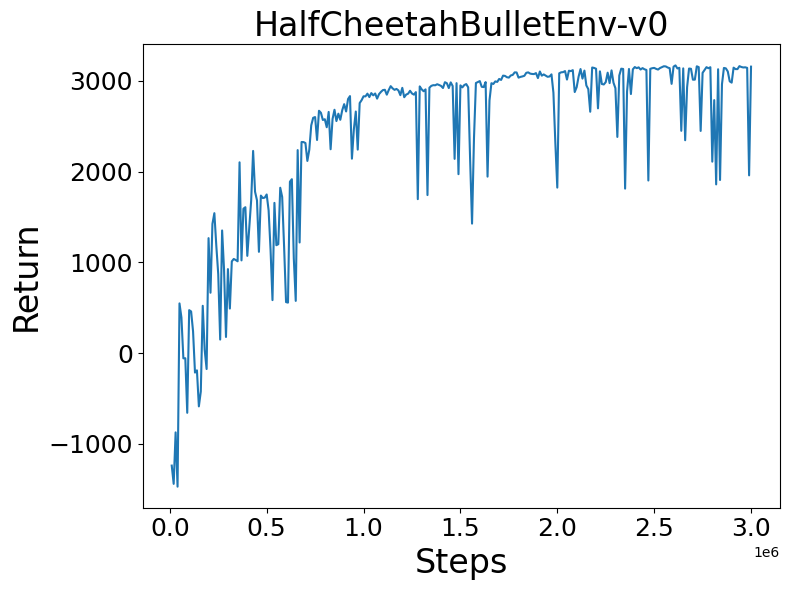

In [ ]:
# 平均収益のグラフ
fig = plt.figure(figsize=(8, 6))
plt.plot(returns['step'], returns['return'])
plt.xlabel('Steps', fontsize=24)
plt.ylabel('Return', fontsize=24)
plt.tick_params(labelsize=18)
plt.title(f'{env.unwrapped.spec.id}', fontsize=24)
plt.tight_layout()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
actor = PPOActor(state_shape=env.observation_space.shape, action_shape=env.action_space.shape)
critic = PPOCritic(state_shape=env.observation_space.shape)
trained_models = TrainedModels(actor, critic)

In [ ]:
trained_models.save("drive/MyDrive/Colab Notebooks")

In [ ]:
monitor_env = gnwrapper.Monitor(make_env(), size=(400, 300),
                                directory='.', video_callable=lambda ep: True)

print('observation space: ', monitor_env.observation_space.shape)
print('action space: ', monitor_env.action_space.shape)

monitor_state = monitor_env.reset()
random = False
done = False
total_reward = 0.
steps = 0
frames = []
actions = []

while not done:
    steps += 1

    if random:
        action = monitor_env.action_space.sample()
    else:
        action = algo.exploit(monitor_state)

    monitor_state, reward, done, _ = monitor_env.step(action)

    total_reward += reward
    frames.append(monitor_state)
    actions.append(action)


print('total reward: ', total_reward)
print('steps: ', steps)

monitor_env.display()

del monitor_env

observation space:  (26,)
action space:  (6,)
total reward:  3140.954309560398
steps:  1000


'rl-video-episode-0.mp4'

In [ ]:
actions = np.stack(actions)

np.save("drive/MyDrive/Colab Notebooks/actions", actions)